$\textbf{Plots for the Monte Carlo control methods}$


In our plots to analyse the Monte Carlo algorithms, we will use three different performance measures.

The first performance measure evaluates the percentage of policies returned by the algorithm different from the optimal policy. Let us refer to this performance measure as the percentage of wrong policies (%WP). We can compute the $\text{%WP}_k$ at episode $k$ over $n$ runs as follows,
\begin{align}
    \text{%WP}_k&=\frac{1}{n}\sum_{i=1}^n1\left\{\arg\min_{a\in\mathcal{A}} Q_k^{(n)}(:,a) \neq \pi^*\right\}\times 100\%.\label{eq: WP percentage}
\end{align}
Here, $Q_k^{(n)}(:,a)$ denotes the vector of $Q$-values for a fixed action $a\in\mathcal{A}(s)$, where the $s$th entry corresponds to state $s\in\mathcal{S}$ during the $k$th episode of the $n$th run of the algorithm. Moreover, the vector $\pi^*\in\{0,1\}^{|\mathcal{S}|}$ denotes the vector in which the $s$th entry consists of the action $a^*$ such that $p(a^*|s)=1$ according to the (deterministic) optimal policy.

Moreover, as the second performance measure we will estimate the mean absolute errors (MAE) of the estimated values under policy $\pi$ averaged over all states. Suppose $n$ runs of the algorithm are conducted, the MAE can then be estimated by
\begin{align*}
    \text{MAE}(\hat{v}^\pi(s))&=\frac{1}{n}\sum_{i=1}^n|v^\pi(s)-\hat{v}^\pi(s)|.
\end{align*}
Here, $v^\pi(s)$ denotes the exact value function in state $s$ under policy $\pi$ and $\hat{v}^\pi(s)$ denotes the estimate of it by the algorithm. 
Now denote by $a^{\pi^*(s)}$ the action $a$ that is chosen according to the (deterministic) optimal policy $\pi^*$ in state $s$. To then investigate the performance of our Monte Carlo control algorithm for each state $s\in\mathcal{S}$, we estimate
\begin{align*}
    \text{MAE}(\hat{Q}(s,a^{\pi^*(s)}))&=\frac{1}{n}\sum_{i=1}^n|v^{*}(s)-\hat{Q}(s,a^{\pi^*(s)})|.
\end{align*}
Here, $v^*(s)$ denotes the optimal value function in state $s$ and $\hat{Q}(s,a^{\pi^*(s)})$ denotes the estimate of it by the algorithm. The MAE averaged over all states can then be computed as follows
\begin{align}
    \frac{1}{N+1}\sum_{s=0}^N\text{MAE}(\hat{Q}(s,a^{\pi^*(s)}))&=\frac{1}{N+1}\sum_{s=0}^N\frac{1}{n}\sum_{i=1}^n|v^{*}(s)-\hat{Q}(s,a^{\pi^*(s)})|. \label{eq: MAE averaged over states}
\end{align}

Similarly as for the MAE, we will investigate the mean squared error (MSE) averaged over all states.
\begin{align}
    \frac{1}{N+1}\sum_{s=0}^N\text{MSE}(\hat{Q}(s,a^{\pi^*(s)}))&=\frac{1}{N+1}\sum_{s=0}^N\frac{1}{n}\sum_{i=1}^n(v^{*}(s)-\hat{Q}(s,a^{\pi^*(s)}))^2,\label{eq: MSE averaged over states}.
\end{align}


The implementation of the first-visit and every-visit Monte Carlo algorithms are given in the code below. We will also use Policy Iteration to compute the optimal value and policy exactly to be able to compute the MAE, MSE, and %WP.

In [3]:


import numpy as np
import time
import matplotlib.pyplot as plt



def First_Visit_Monte_Carlo(alpha, gamma, epsilon,P,C_0,C_1, nrepisodes):
     # in case we want to use one of the three epsilon depending
     # epsilon_type = 2: epsilon = 1/min(episode nr, minimum nr of visits to state s)
     # epsilon_type = 3: epsilon = 1/(minimum nr of visits to state s)
     # epsilon_type = 4: epsilon = 1/(episode nr)
     epsilon_type = epsilon
     
     # size of the state space-1
     N=np.size(P,1)-1
     
     # state space S
     S=np.arange(N+1)
     
     # Initializing Q-values by 0, here the rows correspond to the action and columns to the state
     # i.e., Q is of the form Q[s,a]
     Q=np.zeros([N+1,2])
     
     # setting the Q value for "illegal" actions to infinity
     Q[0,1]=float("inf")
     Q[N,0]=float("inf")
     
     
     # Q value of the reset application
     Q_reset = Q.copy()
     
     
     # n_it[s,a] denotes the number of times (s,a) is visited
     n_it = np.zeros([N+1,2])
     
     # n(s): the number of times the episode started in state s
     n_s0 = np.zeros(N+1)
     
     # m(s): 
     m = np.zeros(N+1)
     
     
     # array containing the T's for each episode
     T_it = []
     
     # Q[s,a,iteration number]: array to keep track of the Q-values per iteration
     Q_it=np.zeros([N+1,2,nrepisodes])
     
     # Q_reset[s,a,iteration number]: array to keep track of the Q-values for the reset application per iteration
     Q_reset_it=np.zeros([N+1,2,nrepisodes])

     # keep track of the the optimal policy according to that episode
     policy_reset_it=np.zeros([N+1,nrepisodes])
     
     # loop for each episode
     for e in range(1,nrepisodes+1):
         # counter to determine the number of visits in (s,a) during the episode
         counter = np.zeros([N+1,2])
         
         # initializing an array containing all states S_{t},S_{t+1},...,S_{t+T}
         states = []
         
         # initializing an array containing all actions A_0,A_1,...,A_T
         actions = []
         
         # initializing an array containing all rewards R_0,R_1,...,R_T
         rewards = []
         
         
         # randomly selecting and storing initial state
         states.append(np.random.randint(0, N+1))
         
         # iteration within the episode
         t = 0
    
         ## select and store an action a_0
         ## epsilon-greedy policy:
         p=np.random.random() # sampling a p in [0,1)
         
         # selecting the epsilon, in case we want a episode/iteration dependent epsilon
         if epsilon_type==2:
         # epsilon = 1/min(episode nr, minimum nr of visits to state s)
             epsilon=1/min(e,max(1,min(n_it[states[0],:])))
         elif epsilon_type==3:
         # epsilon = 1/(minimum nr of visits to state s)
             epsilon=1/max(1,min(n_it[states[0],:]))
         elif epsilon_type==4:
         # epsilon = 1/episode nr
             epsilon = 1/e
         
         # with probability eps: random policy
         if p<epsilon: 
             actions.append(np.random.randint(0, 2)) 
         # with probability 1-eps: greedy policy
         else: 
             # choosing the action that minimizes the Q-value for state s_0,
             # here ties are broken arbitrarily:
             actions.append(np.random.choice(np.flatnonzero(Q_reset[states[0],:] == Q_reset[states[0],:].min())))
         
         # making sure the chosen action is allowed for the state
         if states[0]==0:
             actions[0]=0 
         elif states[0]==N:
             actions[0]=1
             
         while True:
             # taking action A_t 
             # observing and storing the next reward as R_{t+1}
             # and sampling the next state S_{t+1} according to P   
             if actions[t]==1:
                 # append the cost of the state-action pair to the array
                 rewards.append(C_1[states[t]]) 
                 
                 # set the number of time-steps T equal to the t
                 T=t
                 
                 # we check if t>0 to make sure that A_0 = 0
                 if t>0:
                     # the number of times we started in s_0 with a_0=0
                     n_s0[states[0]]+=1
                     
                     # an array with all stopping times T
                     T_it.append(T)
                     
                     # compute m(s_0) using the incremental mean
                     m[states[0]]+=(1/n_s0[states[0]])*(gamma**T-m[states[0]])
                     
                 break
                 
                 
             elif actions[t]==0:
                 # select and store the next action according to P
                 states.append(np.random.choice(S,p=P[states[t],:]))
                 # select and store the cost for action 0 in the current state
                 rewards.append(C_0[states[t]])
               

             
             ## select and store an action A_{t+1} ~ pi(.|S_{t+1}) = eps-greedy policy
             ## epsilon-greedy policy:
             p=np.random.random() # sampling a p in [0,1)
             
             # selecting the epsilon, in case we want a episode/iteration dependent epsilon
             if epsilon_type==2:
             # epsilon = 1/min(episode nr, minimum nr of visits to state s)
                 epsilon=1/min(e,max(1,min(n_it[states[t+1],:])))
             elif epsilon_type==3:
             # epsilon = 1/(minimum nr of visits to state s)
                 epsilon=1/max(1,min(n_it[states[t+1],:]))
             elif epsilon_type==4:
             # epsilon = 1/episode nr
                 epsilon = 1/e
             
             # with probability eps: random policy
             if p<epsilon: 
                 actions.append(np.random.randint(0, 2)) 
             # with probability 1-eps: greedy policy
             else: 
                 # choosing the action that minimizes the Q-value for state s_{t+1},
                 # here ties are broken arbitrarily:
                 #actions.append(np.random.choice(np.flatnonzero(Q[states[t+1],:] == Q[states[t+1],:].min())))
                 actions.append(np.random.choice(np.flatnonzero(Q_reset[states[t+1],:] == Q_reset[states[t+1],:].min())))


             # making sure the randomly chosen action is allowed for the state
             if states[t+1]==0:
                 actions[t+1]=0 
             elif states[t+1]==N:
                 actions[t+1]=1
             
             t+=1
                
         
        
         
         for t in range(0,T+1):
             # incrementing the counter for (s_t,a_t)
             counter[states[t],actions[t]]+=1
             
             # check if it is tbe first-visit to (s_t,a_t)
             if counter[states[t],actions[t]]==1:
                 # G: array containing the return at times t=0,...T
                 G = np.zeros(T+1)
                 
                 # incrementing the nr of visits to (s,a) by 1    
                 n_it[states[t],actions[t]]+=1
                
                 # computing the return G_t
                 G[t] = np.sum([(gamma**i)*rewards[t+i] for i in range(0,T-t+1)])
                
                 # updating the Q-values
                 Q[states[t],actions[t]]+=(1/n_it[states[t],actions[t]])*(G[t]-Q[states[t],actions[t]])
                
                 # keeping track of the (updated) Q-value for the current episode
                 Q_it[states[t],actions[t],e-1]=Q[states[t],actions[t]]
            
        
         # computing the Q-values for the reset application
         Q_reset[0,0] = Q[0,0]/(1-gamma*m[0])
         Q_reset[1:N,0] = Q[1:N,0] + gamma*Q_reset[0,0]*m[1:N]
         Q_reset[1:,1] = Q[1:,1] + gamma*Q_reset[0,0]
         
         # keeping track of the (updated) Q-values and policy for the reset application for the current episode
         Q_reset_it[:,0,e-1] = Q_reset[:,0]
         Q_reset_it[:,1,e-1] = Q_reset[:,1]
         policy_reset_it[:,e-1] = np.argmin(Q_reset, axis=1)
     
     # computing the Q-values for the reset application
     Q_reset[0,0] = Q[0,0]/(1-gamma*m[0])
     Q_reset[1:N,0] = Q[1:N,0] + gamma*Q_reset[0,0]*m[1:N]
     Q_reset[1:,1] = Q[1:,1] + gamma*Q_reset[0,0]
     
     # the optimal policy  
     policy_reset_opt = np.argmin(Q_reset, axis=1)
     v_reset_opt = np.min(Q_reset, axis=1) 
     
                
     return Q, Q_it, n_it,  n_s0, m, T_it, states, actions, rewards,G, Q_reset, policy_reset_opt, Q_reset_it, v_reset_opt,  policy_reset_it



def Every_Visit_Monte_Carlo(alpha, gamma, epsilon,P,C_0,C_1, nrepisodes):
     # in case we want to use one of the three epsilon depending
     # epsilon_type = 2: epsilon = 1/min(episode nr, minimum nr of visits to state s)
     # epsilon_type = 3: epsilon = 1/(minimum nr of visits to state s)
     # epsilon_type = 4: epsilon = 1/(episode nr)
     epsilon_type = epsilon
     
     # size of the state space-1
     N=np.size(P,1)-1
     
     # state space S
     S=np.arange(N+1)
     
     # Initializing Q-values by 0, here the rows correspond to the action and columns to the state
     # i.e., Q is of the form Q[s,a]
     Q=np.zeros([N+1,2])
     
     # setting the Q value for "illegal" actions to infinity
     Q[0,1]=float("inf")
     Q[N,0]=float("inf")
     
     # Q value of the reset application
     Q_reset = Q.copy()

     
     # n_it[s,a] denotes the number of times (s,a) is visited
     n_it = np.zeros([N+1,2])
     
     # n(s): the number of times the episode started in state s
     n_s0 = np.zeros(N+1)
     
     # m(s): 
     m = np.zeros(N+1)
     
     
     # array containing the T's for each episode
     T_it = []
     
     # Q[s,a,episode number]
     Q_it=np.zeros([N+1,2,nrepisodes])
     
     # Q_reset[s,a,episode number]
     Q_reset_it=np.zeros([N+1,2,nrepisodes])
     
     # keep track of the the optimal policy according to that episode
     policy_reset_it=np.zeros([N+1,nrepisodes])
     
     # loop for each episode
     for e in range(1,nrepisodes+1):
         # initializing an array containing all states S_{t},S_{t+1},...,S_{t+T}
         states = []
         
         # initializing an array containing all actions A_0,A_1,...,A_T
         actions = []
         
         # initializing an array containing all rewards R_0,R_1,...,R_T
         rewards = []
         
         
         # randomly selecting and storing initial state
         states.append(np.random.randint(0, N+1))
         
         # iteration within the episode
         t = 0
    
         ## select and store an action a_0
         ## epsilon-greedy policy:
         p=np.random.random() # sampling a p in [0,1)
         
         if epsilon_type==2:
         # epsilon = 1/min(episode nr, minimum nr of visits to state s)
             epsilon=1/min(e,max(1,min(n_it[states[0],:])))
         elif epsilon_type==3:
         # epsilon = 1/(minimum nr of visits to state s)
             epsilon=1/max(1,min(n_it[states[0],:]))
         elif epsilon_type==4:
         # epsilon = 1/episode nr
             epsilon = 1/e
         
         # with probability eps: random policy
         if p<epsilon: 
             actions.append(np.random.randint(0, 2)) 
         # with probability 1-eps: greedy policy
         else: 
             # choosing the action that minimizes the Q-value for state s_0,
             # here ties are broken arbitrarily:
             actions.append(np.random.choice(np.flatnonzero(Q_reset[states[0],:] == Q_reset[states[0],:].min())))
         
         
         # making sure the chosen action is allowed for the state
         if states[0]==0:
             actions[0]=0 
         elif states[0]==N:
             actions[0]=1
             
         while True:
             # taking action A_t 
             # observing and storing the next reward as R_{t+1}
             # and sampling the next state S_{t+1} according to P   
             if actions[t]==1:
                 # append the cost of the state-action pair to the array
                 rewards.append(C_1[states[t]]) 
                 
                 # set the number of time-steps T equal to the t
                 T=t
                 
                 # we check if t>0 to make sure that A_0 = 0
                 if t>0:
                     # the number of times we started in s_0 with a_0=0
                     n_s0[states[0]]+=1
                     
                     # an array with all stopping times T
                     T_it.append(T)
                     
                     # compute m(s_0) using the incremental mean
                     m[states[0]]+=(1/n_s0[states[0]])*(gamma**T-m[states[0]])  
                 break
                 
             elif actions[t]==0:
                 # select and store the next action according to P
                 states.append(np.random.choice(S,p=P[states[t],:]))
                 # select and store the cost for action 0 in the current state
                 rewards.append(C_0[states[t]])
               

             
             ## select and store an action A_{t+1} ~ pi(.|S_{t+1}) = eps-greedy policy
             ## epsilon-greedy policy:
             p=np.random.random() # sampling a p in [0,1)
             
             if epsilon_type==2:
             # epsilon = 1/min(episode nr, minimum nr of visits to state s)
                 epsilon=1/min(e,max(1,min(n_it[states[t+1],:])))
             elif epsilon_type==3:
             # epsilon = 1/(minimum nr of visits to state s)
                 epsilon=1/max(1,min(n_it[states[t+1],:]))
             elif epsilon_type==4:
             # epsilon = 1/episode nr
                 epsilon = 1/e
             
             
             # with probability eps: random policy
             if p<epsilon: 
                 actions.append(np.random.randint(0, 2)) 
             # with probability 1-eps: greedy policy
             else: 
                 # choosing the action that minimizes the Q-value for state s_{t+1},
                 # here ties are broken arbitrarily:
                 actions.append(np.random.choice(np.flatnonzero(Q_reset[states[t+1],:] == Q_reset[states[t+1],:].min())))


             # making sure the randomly chosen action is allowed for the state
             if states[t+1]==0:
                 actions[t+1]=0 
             elif states[t+1]==N:
                 actions[t+1]=1
             
             t+=1
                
         
         
         
         for t in range(0,T+1):
             # G: array containing the return at times t=0,...T
             G = np.zeros(T+1)
             
             # incrementing the nr of visits to (s,a) by 1    
             n_it[states[t],actions[t]]+=1
            
             # computing the return G_t
             G[t] = np.sum([(gamma**i)*rewards[t+i] for i in range(0,T-t+1)])
                
             # updating the Q-values   
             Q[states[t],actions[t]]+=(1/n_it[states[t],actions[t]])*(G[t]-Q[states[t],actions[t]])
            
             # keeping track of the (updated) Q-value for the current episode
             Q_it[states[t],actions[t],e-1]=Q[states[t],actions[t]]
        
         # computing the Q-values for the reset application
         Q_reset[0,0] = Q[0,0]/(1-gamma*m[0])
         Q_reset[1:N,0] = Q[1:N,0] + gamma*Q_reset[0,0]*m[1:N]
         Q_reset[1:,1] = Q[1:,1] + gamma*Q_reset[0,0]
         
         # keeping track of the (updated) Q-values and policy for the reset application for the current episode   
         Q_reset_it[:,0,e-1] = Q_reset[:,0]
         Q_reset_it[:,1,e-1] = Q_reset[:,1]
         policy_reset_it[:,e-1] = np.argmin(Q_reset, axis=1)
     
     # computing the Q-values for the reset application
     Q_reset[0,0] = Q[0,0]/(1-gamma*m[0])
     Q_reset[1:N,0] = Q[1:N,0] + gamma*Q_reset[0,0]*m[1:N]
     Q_reset[1:,1] = Q[1:,1] + gamma*Q_reset[0,0]
     
     # the optimal policy  
     policy_reset_opt = np.argmin(Q_reset, axis=1)
     v_reset_opt = np.min(Q_reset, axis=1) 
         
     return Q, Q_it, n_it, n_s0, m, T_it, states, actions, rewards,G, Q_reset, policy_reset_opt, Q_reset_it, v_reset_opt, policy_reset_it



# Policy Evaluation
def Policy_Evaluation_2_actions(gamma,P,C_0,C_1,pi_s):
    N=np.size(P,1)-1
    
    P_pi=P.copy()
    
    # nonzeros(pi_s) returns the index of the nonzero elements, i.e. action=1
    # in the rows corresponding to this index we change the P
    # so that we will reset to state 0 w.p. 1
    P_pi[np.nonzero(pi_s)]=np.identity(N+1)[0]
    
    C=C_0.copy()
    C[np.nonzero(pi_s)]=C_1[np.nonzero(pi_s)]
    
    # x=linalg.solve(a,b) solves ax=b
    # in our case we solve (I-gamma*P)V=C
    Vn = np.linalg.solve(np.identity(N+1)-gamma*P_pi,C)
    
    return Vn


# policy improvement step
def Policy_Improvement_2_actions(gamma,P,C_0,C_1,pi_s,Vn):  
    # initializing N and several value functions
    N=np.size(P,1)-1
    Vn_0=np.zeros(N+1)
    Vn_1=np.zeros(N+1)
    
    # value function if action=0 was chosen for all states
    Vn_0=C_0+gamma*P@Vn 
    # value function if action=1 was chosen for all states
    Vn_1=C_1+gamma*np.repeat(Vn[0],N+1) 
    
    
    # finding the action that minimizes the value function for each state
    # here, axis=0 looks for row (=action) for which the value in the column (=state) is minimized
    policy=np.argmin(np.array([Vn_0,Vn_1]),axis=0)
    
    return policy 

alpha=20



Let us investigate a suitable choice for epsilon for the Monte Carlo algorithm using the MAE, MSE, and %WP for cost realization 1 with $\mathcal{P}_B$, $\gamma=0.3$, and $N=3$. In particular, we will investigate the following $\epsilon$:

1. fixed small $\epsilon$,
2. $\epsilon_k=\frac{1}{k}$, where $k$ denotes the episode number,
3. $\epsilon_t=\frac{1}{\min\{n_t(s,0),n_t(s,1)\}}$, where $t$ denotes the iteration number,
4. $\epsilon_t=\frac{1}{\min\{k,n_t(s,0),n_t(s,1)\}}$.

In [2]:

# discount factor
gamma=0.3

# nr of episodes
nrepisodes = 2000

# number of states - 1
N=3


## transition matrix 
# P_B
P = np.diag(1/2*np.ones(N),1)+np.diag(1/2*np.ones(N),-1)
P[-1,-2]=1
P[0,1]=1


## Realization 1

# Cost for action = 0
C_0=np.zeros(N+1)

# Cost for action = 1
C_1=np.arange(N+1,dtype=float)
C_1[N]=2*N


We compute the optimal value and optimal policy exactly using Policy Iteration. This exact solution will then be used to compute the MAE, MSE and %WP.

In [3]:

nrruns=100

# Putting the cost for "illegal actions" to infinity
C_0[N]=float("inf")
C_1[0]=float("inf")


# Initializing the value function
V=np.zeros(N+1)

# Initializing the policy
pi_s = np.ones(N+1,dtype=int)
pi_s[0]=0

# Number of iterations counter
it=0
while True:
    # Policy evaluation for policy pi_s
    V=Policy_Evaluation_2_actions(gamma,P,C_0,C_1,pi_s)
    
    # Policy improvement of policy pi_s
    policy = Policy_Improvement_2_actions(gamma,P,C_0,C_1,pi_s,V)
    
    # Incrementing the number of iterations by 1
    it+=1
    
    # Checking if the policy has changed
    if all(pi_s==policy):
        break
    
    # Assigning the improved policy to pi_s
    pi_s=policy.copy()


opt_policy = policy.copy()



MSE_FV_0_it = np.zeros([nrruns,nrepisodes])
MSE_FV_1_it = np.zeros([nrruns,nrepisodes])
MSE_FV_2_it = np.zeros([nrruns,nrepisodes])
MSE_FV_3_it = np.zeros([nrruns,nrepisodes])
MSE_FV_4_it = np.zeros([nrruns,nrepisodes])


MAE_FV_0_it = np.zeros([nrruns,nrepisodes])
MAE_FV_1_it = np.zeros([nrruns,nrepisodes])
MAE_FV_2_it = np.zeros([nrruns,nrepisodes])
MAE_FV_3_it = np.zeros([nrruns,nrepisodes])
MAE_FV_4_it = np.zeros([nrruns,nrepisodes])

policy_count_eps0 = np.zeros([nrruns,nrepisodes])
policy_count_eps1 = np.zeros([nrruns,nrepisodes])
policy_count_eps2 = np.zeros([nrruns,nrepisodes])
policy_count_eps3 = np.zeros([nrruns,nrepisodes])
policy_count_eps4 = np.zeros([nrruns,nrepisodes])


# epsilon in epsilon-greedy:
     # in case we want to use one of the three epsilon depending
     # epsilon_type = 2: epsilon = 1/min(episode nr, minimum nr of visits to state s)
     # epsilon_type = 3: epsilon = 1/(minimum nr of visits to state s)
     # epsilon_type = 4: epsilon = 1/(episode nr) 
for i in range(0,nrruns):
    epsilon=0.05
    Q, Q_it, n_it, n_s0, m, T_it, states, actions, rewards,G, Q_reset_eps0, policy_reset_opt_eps0, Q_reset_it_eps0, v_reset_opt_eps0,policy_reset_it0 = First_Visit_Monte_Carlo(alpha, gamma, epsilon,P,C_0,C_1, nrepisodes)  

    epsilon=0.2
    Q, Q_it, n_it, n_s0, m, T_it, states, actions, rewards,G, Q_reset_eps1, policy_reset_opt_eps1, Q_reset_it_eps1, v_reset_opt_eps1,policy_reset_it1 = First_Visit_Monte_Carlo(alpha, gamma, epsilon,P,C_0,C_1, nrepisodes)  

    
    epsilon=2
    Q, Q_it, n_it, n_s0, m, T_it, states, actions, rewards,G, Q_reset_eps2, policy_reset_opt_eps2, Q_reset_it_eps2, v_reset_opt_eps2,policy_reset_it2 = First_Visit_Monte_Carlo(alpha, gamma, epsilon,P,C_0,C_1, nrepisodes)  


    epsilon=3
    Q, Q_it, n_it, n_s0, m, T_it, states, actions, rewards,G, Q_reset_eps3, policy_reset_opt_eps3, Q_reset_it_eps3, v_reset_opt_eps3,policy_reset_it3 = First_Visit_Monte_Carlo(alpha, gamma, epsilon,P,C_0,C_1, nrepisodes)  


    epsilon=4
    Q, Q_it, n_it, n_s0, m, T_it, states, actions, rewards,G, Q_reset_eps4, policy_reset_opt_eps4, Q_reset_it_eps4, v_reset_opt_eps4,policy_reset_it4 = First_Visit_Monte_Carlo(alpha, gamma, epsilon,P,C_0,C_1, nrepisodes)  

    #1/(N+1) * sum_{s=0}^N (Q(s,pi^*(s))-V(s))^2 computed for each episode
    MSE_FV_0_it[i,:] = np.mean(np.array([(Q_reset_it_eps0[j,opt_policy[j],:]-V[j])**2 for j in range(0,N+1)]),axis=0)
    MSE_FV_1_it[i,:] = np.mean(np.array([(Q_reset_it_eps1[j,opt_policy[j],:]-V[j])**2 for j in range(0,N+1)]),axis=0)
    MSE_FV_2_it[i,:] = np.mean(np.array([(Q_reset_it_eps2[j,opt_policy[j],:]-V[j])**2 for j in range(0,N+1)]),axis=0)
    MSE_FV_3_it[i,:] = np.mean(np.array([(Q_reset_it_eps3[j,opt_policy[j],:]-V[j])**2 for j in range(0,N+1)]),axis=0)
    MSE_FV_4_it[i,:] = np.mean(np.array([(Q_reset_it_eps4[j,opt_policy[j],:]-V[j])**2 for j in range(0,N+1)]),axis=0)
    
    # 1/(N+1) * sum_{s=0}^N |Q(s,pi^*(s))-V(s)| computed for each episode
    MAE_FV_0_it[i,:] = np.mean(np.array([abs(Q_reset_it_eps0[j,opt_policy[j],:]-V[j]) for j in range(0,N+1)]),axis=0)
    MAE_FV_1_it[i,:] = np.mean(np.array([abs(Q_reset_it_eps1[j,opt_policy[j],:]-V[j]) for j in range(0,N+1)]),axis=0)
    MAE_FV_2_it[i,:] = np.mean(np.array([abs(Q_reset_it_eps2[j,opt_policy[j],:]-V[j]) for j in range(0,N+1)]),axis=0)
    MAE_FV_3_it[i,:] = np.mean(np.array([abs(Q_reset_it_eps3[j,opt_policy[j],:]-V[j]) for j in range(0,N+1)]),axis=0)
    MAE_FV_4_it[i,:] = np.mean(np.array([abs(Q_reset_it_eps4[j,opt_policy[j],:]-V[j]) for j in range(0,N+1)]),axis=0)
    
    
    
    
    ## checking if the policy at run i is wrong (=1) for all episodes in the run
    policy_count_eps0[i,:] = (abs(np.transpose(np.tile(opt_policy, (nrepisodes,1)))-policy_reset_it0).sum(axis=0) != 0).astype(int)
    policy_count_eps1[i,:] = (abs(np.transpose(np.tile(opt_policy, (nrepisodes,1)))-policy_reset_it1).sum(axis=0) != 0).astype(int)
    policy_count_eps2[i,:] = (abs(np.transpose(np.tile(opt_policy, (nrepisodes,1)))-policy_reset_it2).sum(axis=0) != 0).astype(int)
    policy_count_eps3[i,:] =  (abs(np.transpose(np.tile(opt_policy, (nrepisodes,1)))-policy_reset_it3).sum(axis=0) != 0).astype(int)
    policy_count_eps4[i,:] =  (abs(np.transpose(np.tile(opt_policy, (nrepisodes,1)))-policy_reset_it4).sum(axis=0) != 0).astype(int)
 

# 1/nrruns * sum_{i=1}^nrruns  1/(N+1) * sum_{s=0}^N (Q(s,pi^*(s))-V(s))^2 computed for each episode
MSE_FV_0 = np.mean(MSE_FV_0_it, axis=0)
MSE_FV_1 = np.mean(MSE_FV_1_it, axis=0)
MSE_FV_2 = np.mean(MSE_FV_2_it, axis=0)
MSE_FV_3 = np.mean(MSE_FV_3_it, axis=0)
MSE_FV_4 = np.mean(MSE_FV_4_it, axis=0)

# 1/nrruns * sum_{i=1}^nrruns  1/(N+1) * sum_{s=0}^N |Q(s,pi^*(s))-V(s)| computed for each episode
MAE_FV_0 = np.mean(MAE_FV_0_it, axis=0)
MAE_FV_1 = np.mean(MAE_FV_1_it, axis=0)
MAE_FV_2 = np.mean(MAE_FV_2_it, axis=0)
MAE_FV_3 = np.mean(MAE_FV_3_it, axis=0)
MAE_FV_4 = np.mean(MAE_FV_4_it, axis=0)


policy_perc_eps0 = np.mean(policy_count_eps0, axis=0)
policy_perc_eps1 = np.mean(policy_count_eps1, axis=0)
policy_perc_eps2 = np.mean(policy_count_eps2, axis=0)
policy_perc_eps3 = np.mean(policy_count_eps3,axis=0)
policy_perc_eps4 = np.mean(policy_count_eps4,axis=0)


Creating the plots for the MSE, MAE, and %WP:

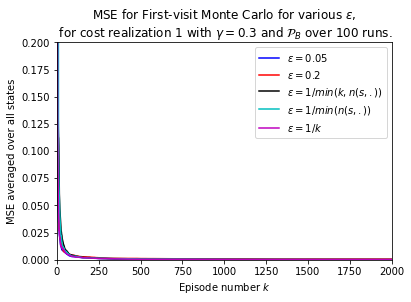

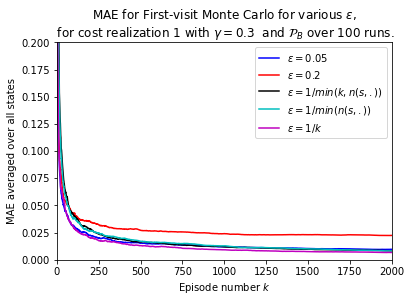

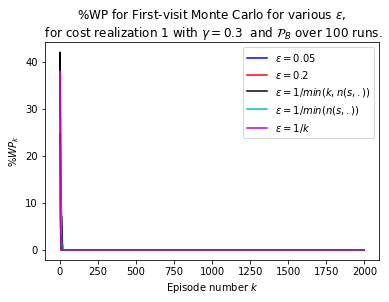

In [5]:
fig0, ax0 = plt.subplots()


ax0.plot(np.arange(nrepisodes),MSE_FV_0,'b-',label='$\epsilon=0.05$')

ax0.plot(np.arange(nrepisodes),MSE_FV_1,'r-',label='$\epsilon=0.2$')

ax0.plot(np.arange(nrepisodes),MSE_FV_2,'k-',label='$\epsilon=1/min(k,n(s,.))$')

ax0.plot(np.arange(nrepisodes),MSE_FV_3,'c-',label='$\epsilon=1/min(n(s,.))$')

ax0.plot(np.arange(nrepisodes),MSE_FV_4,'m-',label='$\epsilon=1/k$')

ax0.set(xlim=(0, nrepisodes), ylim=(0,0.2))

plt.title(r'MSE for First-visit Monte Carlo for various $\epsilon,$'+'\n for cost realization 1 with $\gamma=$'+str(gamma)+' and $\mathcal{P}_B$ over 100 runs.')
plt.xlabel('Episode number $k$')
plt.ylabel('MSE averaged over all states')
plt.legend() 


fig1, ax1 = plt.subplots()

ax1.plot(np.arange(nrepisodes),MAE_FV_0,'b-',label='$\epsilon=0.05$')

ax1.plot(np.arange(nrepisodes),MAE_FV_1,'r-',label='$\epsilon=0.2$')

ax1.plot(np.arange(nrepisodes),MAE_FV_2,'k-',label='$\epsilon=1/min(k,n(s,.))$')

ax1.plot(np.arange(nrepisodes),MAE_FV_3,'c-',label='$\epsilon=1/min(n(s,.))$')

ax1.plot(np.arange(nrepisodes),MAE_FV_4,'m-',label='$\epsilon=1/k$')
ax1.set(xlim=(0, nrepisodes), ylim=(0,0.2))


plt.title(r'MAE for First-visit Monte Carlo for various $\epsilon,$'+'\n for cost realization 1 with $\gamma=$'+str(gamma)+'  and $\mathcal{P}_B$ over 100 runs.')
plt.xlabel('Episode number $k$')
plt.ylabel('MAE averaged over all states')
plt.legend() 



fig2, ax2 = plt.subplots()


ax2.plot(np.arange(nrepisodes),100*policy_perc_eps0,'b-',label='$\epsilon=0.05$')
ax2.plot(np.arange(nrepisodes),100*policy_perc_eps1,'r-',label='$\epsilon=0.2$')
ax2.plot(np.arange(nrepisodes),100*policy_perc_eps2,'k-',label='$\epsilon=1/min(k,n(s,.))$')
ax2.plot(np.arange(nrepisodes),100*policy_perc_eps3,'c-',label='$\epsilon=1/min(n(s,.))$')
ax2.plot(np.arange(nrepisodes),100*policy_perc_eps4,'m-',label='$\epsilon=1/k$')



plt.title(r'%WP for First-visit Monte Carlo for various $\epsilon,$'+'\n for cost realization 1 with $\gamma=$'+str(gamma)+'  and $\mathcal{P}_B$ over 100 runs.')
plt.xlabel('Episode number $k$')
plt.ylabel('%$WP_k$')
plt.legend() 


Next, we compare first-visit and every-visit Monte Carlo algorithms using the using the MAE, MSE, and %WP for $\epsilon=0.05$ and $\epsilon_t=\frac{1}{\min\{n_t(s,0),n_t(s,1)\}}$.

In [6]:

## comparing FV with EV


start=time.time()

nrruns=100

# Putting the cost for "illegal actions" to infinity
C_0[N]=float("inf")
C_1[0]=float("inf")


# Initializing the value function
V=np.zeros(N+1)

# Initializing the policy
pi_s = np.ones(N+1,dtype=int)
pi_s[0]=0

# Number of iterations counter
it=0
while True:
    # Policy evaluation for policy pi_s
    V=Policy_Evaluation_2_actions(gamma,P,C_0,C_1,pi_s)
    
    # Policy improvement of policy pi_s
    policy = Policy_Improvement_2_actions(gamma,P,C_0,C_1,pi_s,V)
    
    # Incrementing the number of iterations by 1
    it+=1
    
    # Checking if the policy has changed
    if all(pi_s==policy):
        break
    
    # Assigning the improved policy to pi_s
    pi_s=policy.copy()


opt_policy = policy.copy()


MSE_FV_0_it = np.zeros([nrruns,nrepisodes])
MSE_FV_3_it = np.zeros([nrruns,nrepisodes])
MSE_EV_0_it = np.zeros([nrruns,nrepisodes])
MSE_EV_3_it = np.zeros([nrruns,nrepisodes])


MAE_FV_0_it = np.zeros([nrruns,nrepisodes])
MAE_FV_3_it = np.zeros([nrruns,nrepisodes])
MAE_EV_0_it = np.zeros([nrruns,nrepisodes])
MAE_EV_3_it = np.zeros([nrruns,nrepisodes])

policy_count_FV0 = np.zeros([nrruns,nrepisodes])
policy_count_FV3 = np.zeros([nrruns,nrepisodes])
policy_count_EV0 = np.zeros([nrruns,nrepisodes])
policy_count_EV3 = np.zeros([nrruns,nrepisodes])


# epsilon in epsilon-greedy:
     # in case we want to use one of the three epsilon depending
     # epsilon_type = 2: epsilon = 1/min(episode nr, minimum nr of visits to state s)
     # epsilon_type = 3: epsilon = 1/(minimum nr of visits to state s)
     # epsilon_type = 4: epsilon = 1/(episode nr) 
for i in range(0,nrruns):
    epsilon=0.05
    Q, Q_it, n_it, n_s0, m, T_it, states, actions, rewards,G, Q_reset_FV0, policy_reset_opt_FV0, Q_reset_it_FV0, v_reset_opt_FV0,policy_reset_itFV0 = First_Visit_Monte_Carlo(alpha, gamma, epsilon,P,C_0,C_1, nrepisodes)  
    Q, Q_it, n_it, n_s0, m, T_it, states, actions, rewards,G, Q_reset_EV0, policy_reset_opt_EV0, Q_reset_it_EV0, v_reset_opt_EV0,policy_reset_itEV0 = Every_Visit_Monte_Carlo(alpha, gamma, epsilon,P,C_0,C_1, nrepisodes)  

    epsilon=3
    Q, Q_it, n_it, n_s0, m, T_it, states, actions, rewards,G, Q_reset_FV3, policy_reset_opt_FV3, Q_reset_it_FV3, v_reset_opt_FV3,policy_reset_itFV3 = First_Visit_Monte_Carlo(alpha, gamma, epsilon,P,C_0,C_1, nrepisodes)  
    Q, Q_it, n_it, n_s0, m, T_it, states, actions, rewards,G, Q_reset_EV3, policy_reset_opt_EV3, Q_reset_it_EV3, v_reset_opt_EV3,policy_reset_itEV3 = Every_Visit_Monte_Carlo(alpha, gamma, epsilon,P,C_0,C_1, nrepisodes)  


    #1/(N+1) * sum_{s=0}^N (Q(s,pi^*(s))-V(s))^2 computed for each episode
    MSE_FV_0_it[i,:] = np.mean(np.array([(Q_reset_it_FV0[j,opt_policy[j],:]-V[j])**2 for j in range(0,N+1)]),axis=0)
    MSE_FV_3_it[i,:] = np.mean(np.array([(Q_reset_it_FV3[j,opt_policy[j],:]-V[j])**2 for j in range(0,N+1)]),axis=0)
    MSE_EV_0_it[i,:] = np.mean(np.array([(Q_reset_it_EV0[j,opt_policy[j],:]-V[j])**2 for j in range(0,N+1)]),axis=0)
    MSE_EV_3_it[i,:] = np.mean(np.array([(Q_reset_it_EV3[j,opt_policy[j],:]-V[j])**2 for j in range(0,N+1)]),axis=0)
  
    # 1/(N+1) * sum_{s=0}^N |Q(s,pi^*(s))-V(s)| computed for each episode
    MAE_FV_0_it[i,:] = np.mean(np.array([abs(Q_reset_it_FV0[j,opt_policy[j],:]-V[j]) for j in range(0,N+1)]),axis=0)
    MAE_FV_3_it[i,:] = np.mean(np.array([abs(Q_reset_it_FV3[j,opt_policy[j],:]-V[j]) for j in range(0,N+1)]),axis=0)
    MAE_EV_0_it[i,:] = np.mean(np.array([abs(Q_reset_it_EV0[j,opt_policy[j],:]-V[j]) for j in range(0,N+1)]),axis=0)
    MAE_EV_3_it[i,:] = np.mean(np.array([abs(Q_reset_it_EV3[j,opt_policy[j],:]-V[j]) for j in range(0,N+1)]),axis=0)

    
    
    ## checking if the policy at run i is wrong (=1) for all episodes in the run
    policy_count_FV0[i,:] = (abs(np.transpose(np.tile(opt_policy, (nrepisodes,1)))-policy_reset_itFV0).sum(axis=0) != 0).astype(int)
    policy_count_FV3[i,:] = (abs(np.transpose(np.tile(opt_policy, (nrepisodes,1)))-policy_reset_itFV3).sum(axis=0) != 0).astype(int)
    policy_count_EV0[i,:] = (abs(np.transpose(np.tile(opt_policy, (nrepisodes,1)))-policy_reset_itEV0).sum(axis=0) != 0).astype(int)
    policy_count_EV3[i,:] =  (abs(np.transpose(np.tile(opt_policy, (nrepisodes,1)))-policy_reset_itEV3).sum(axis=0) != 0).astype(int)


# 1/nrruns * sum_{i=1}^nrruns  1/(N+1) * sum_{s=0}^N (Q(s,pi^*(s))-V(s))^2 computed for each episode
MSE_FV_0 = np.mean(MSE_FV_0_it, axis=0)
MSE_FV_3 = np.mean(MSE_FV_3_it, axis=0)
MSE_EV_0 = np.mean(MSE_EV_0_it, axis=0)
MSE_EV_3 = np.mean(MSE_EV_3_it, axis=0)

# 1/nrruns * sum_{i=1}^nrruns  1/(N+1) * sum_{s=0}^N |Q(s,pi^*(s))-V(s)| computed for each episode
MAE_FV_0 = np.mean(MAE_FV_0_it, axis=0)
MAE_FV_3 = np.mean(MAE_FV_3_it, axis=0)
MAE_EV_0 = np.mean(MAE_EV_0_it, axis=0)
MAE_EV_3 = np.mean(MAE_EV_3_it, axis=0)


policy_perc_FV0 = np.mean(policy_count_FV0, axis=0)
policy_perc_FV3 = np.mean(policy_count_FV3, axis=0)
policy_perc_EV0 = np.mean(policy_count_EV0, axis=0)
policy_perc_EV3 = np.mean(policy_count_EV3,axis=0)


Creating the plots for the MSE, MAE, and %WP:

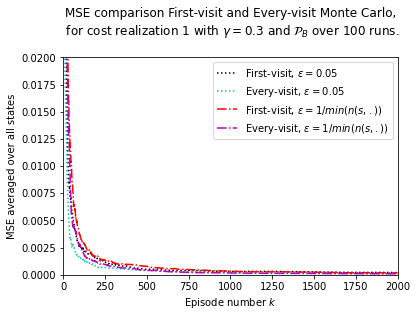

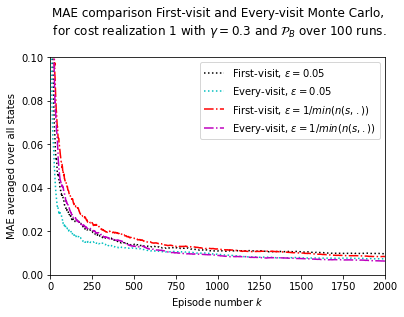

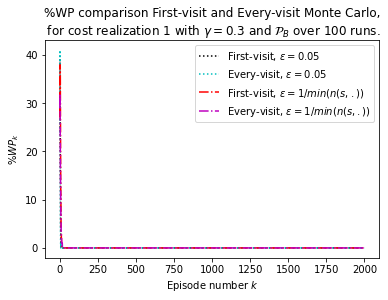

In [9]:
fig0, ax0 = plt.subplots()


ax0.plot(np.arange(nrepisodes),MSE_FV_0,'k:',label='First-visit, $\epsilon=0.05$')

ax0.plot(np.arange(nrepisodes),MSE_EV_0,'c:',label='Every-visit, $\epsilon=0.05$')


ax0.plot(np.arange(nrepisodes),MSE_FV_3,'r-.',label='First-visit, $\epsilon=1/min(n(s,.))$')

ax0.plot(np.arange(nrepisodes),MSE_EV_3,'m-.',label='Every-visit, $\epsilon=1/min(n(s,.))$')

ax0.set(xlim=(0, nrepisodes), ylim=(0,0.02))

plt.title(r'MSE comparison First-visit and Every-visit Monte Carlo,'+'\n for cost realization 1 with $\gamma=$'+str(gamma)+' and $\mathcal{P}_B$ over 100 runs.'+'\n')

plt.xlabel('Episode number $k$')
plt.ylabel('MSE averaged over all states')
plt.legend() 



fig1, ax1 = plt.subplots()


ax1.plot(np.arange(nrepisodes),MAE_FV_0,'k:',label='First-visit, $\epsilon=0.05$')

ax1.plot(np.arange(nrepisodes),MAE_EV_0,'c:',label='Every-visit, $\epsilon=0.05$')


ax1.plot(np.arange(nrepisodes),MAE_FV_3,'r-.',label='First-visit, $\epsilon=1/min(n(s,.))$')

ax1.plot(np.arange(nrepisodes),MAE_EV_3,'m-.',label='Every-visit, $\epsilon=1/min(n(s,.))$')

ax1.set(xlim=(0, nrepisodes), ylim=(0,0.1))

plt.title(r'MAE comparison First-visit and Every-visit Monte Carlo,'+'\n for cost realization 1 with $\gamma=$'+str(gamma)+' and $\mathcal{P}_B$ over 100 runs.'+'\n')

plt.xlabel('Episode number $k$')
plt.ylabel('MAE averaged over all states')
plt.legend() 


fig2, ax2 = plt.subplots()


ax2.plot(np.arange(nrepisodes),100*policy_perc_FV0,'k:',label='First-visit, $\epsilon=0.05$')
ax2.plot(np.arange(nrepisodes),100*policy_perc_EV0,'c:',label='Every-visit, $\epsilon=0.05$')
ax2.plot(np.arange(nrepisodes),100*policy_perc_FV3,'r-.',label='First-visit, $\epsilon=1/min(n(s,.))$')
ax2.plot(np.arange(nrepisodes),100*policy_perc_EV3,'m-.',label='Every-visit, $\epsilon=1/min(n(s,.))$')



plt.title(r'%WP comparison First-visit and Every-visit Monte Carlo,'+'\n for cost realization 1 with $\gamma=$'+str(gamma)+' and $\mathcal{P}_B$ over 100 runs.')
plt.xlabel('Episode number $k$')
plt.ylabel('%$WP_k$')
plt.legend() 


Finally, we compare first-visit and every-visit Monte Carlo algorithms for larger $N$ for $\epsilon=0.05$ and $\epsilon_t=\frac{1}{\min\{n_t(s,0),n_t(s,1)\}}$.

In [5]:
# discount factor
gamma=0.3

# nr of episodes
nrepisodes = 2000


# number of states - 1
N=200

# probability transition matrix 
# P_B
P = np.diag(1/2*np.ones(N),1)+np.diag(1/2*np.ones(N),-1)
P[-1,-2]=1
P[0,1]=1


# Realization 1

# Cost for action = 0
C_0=np.zeros(N+1)

# Cost for action = 1
C_1=np.arange(N+1,dtype=float)
C_1[N]=2*N


In [6]:


nrruns=100

# Putting the cost for "illegal actions" to infinity
C_0[N]=float("inf")
C_1[0]=float("inf")


# Initializing the value function
V=np.zeros(N+1)

# Initializing the policy
pi_s = np.ones(N+1,dtype=int)
pi_s[0]=0

# Number of iterations counter
it=0
while True:
    # Policy evaluation for policy pi_s
    V=Policy_Evaluation_2_actions(gamma,P,C_0,C_1,pi_s)
    
    # Policy improvement of policy pi_s
    policy = Policy_Improvement_2_actions(gamma,P,C_0,C_1,pi_s,V)
    
    # Incrementing the number of iterations by 1
    it+=1
    
    # Checking if the policy has changed
    if all(pi_s==policy):
        break
    
    # Assigning the improved policy to pi_s
    pi_s=policy.copy()


opt_policy = policy.copy()


MSE_FV_0_it = np.zeros([nrruns,nrepisodes])
MSE_FV_3_it = np.zeros([nrruns,nrepisodes])
MSE_EV_0_it = np.zeros([nrruns,nrepisodes])
MSE_EV_3_it = np.zeros([nrruns,nrepisodes])


MAE_FV_0_it = np.zeros([nrruns,nrepisodes])
MAE_FV_3_it = np.zeros([nrruns,nrepisodes])
MAE_EV_0_it = np.zeros([nrruns,nrepisodes])
MAE_EV_3_it = np.zeros([nrruns,nrepisodes])

policy_count_FV0 = np.zeros([nrruns,nrepisodes])
policy_count_FV3 = np.zeros([nrruns,nrepisodes])
policy_count_EV0 = np.zeros([nrruns,nrepisodes])
policy_count_EV3 = np.zeros([nrruns,nrepisodes])


# epsilon in epsilon-greedy:
     # in case we want to use one of the three epsilon depending
     # epsilon_type = 2: epsilon = 1/min(episode nr, minimum nr of visits to state s)
     # epsilon_type = 3: epsilon = 1/(minimum nr of visits to state s)
     # epsilon_type = 4: epsilon = 1/(episode nr) 
for i in range(0,nrruns):
    epsilon=0.05
    Q, Q_it, n_it, n_s0, m, T_it, states, actions, rewards,G, Q_reset_FV0, policy_reset_opt_FV0, Q_reset_it_FV0, v_reset_opt_FV0,policy_reset_itFV0 = First_Visit_Monte_Carlo(alpha, gamma, epsilon,P,C_0,C_1, nrepisodes)  
    Q, Q_it, n_it, n_s0, m, T_it, states, actions, rewards,G, Q_reset_EV0, policy_reset_opt_EV0, Q_reset_it_EV0, v_reset_opt_EV0,policy_reset_itEV0 = Every_Visit_Monte_Carlo(alpha, gamma, epsilon,P,C_0,C_1, nrepisodes)  

    epsilon=3
    Q, Q_it, n_it, n_s0, m, T_it, states, actions, rewards,G, Q_reset_FV3, policy_reset_opt_FV3, Q_reset_it_FV3, v_reset_opt_FV3,policy_reset_itFV3 = First_Visit_Monte_Carlo(alpha, gamma, epsilon,P,C_0,C_1, nrepisodes)  
    Q, Q_it, n_it, n_s0, m, T_it, states, actions, rewards,G, Q_reset_EV3, policy_reset_opt_EV3, Q_reset_it_EV3, v_reset_opt_EV3,policy_reset_itEV3 = Every_Visit_Monte_Carlo(alpha, gamma, epsilon,P,C_0,C_1, nrepisodes)  


    #1/(N+1) * sum_{s=0}^N (Q(s,pi^*(s))-V(s))^2 computed for each episode
    MSE_FV_0_it[i,:] = np.mean(np.array([(Q_reset_it_FV0[j,opt_policy[j],:]-V[j])**2 for j in range(0,N+1)]),axis=0)
    MSE_FV_3_it[i,:] = np.mean(np.array([(Q_reset_it_FV3[j,opt_policy[j],:]-V[j])**2 for j in range(0,N+1)]),axis=0)
    MSE_EV_0_it[i,:] = np.mean(np.array([(Q_reset_it_EV0[j,opt_policy[j],:]-V[j])**2 for j in range(0,N+1)]),axis=0)
    MSE_EV_3_it[i,:] = np.mean(np.array([(Q_reset_it_EV3[j,opt_policy[j],:]-V[j])**2 for j in range(0,N+1)]),axis=0)
  
    # 1/(N+1) * sum_{s=0}^N |Q(s,pi^*(s))-V(s)| computed for each episode
    MAE_FV_0_it[i,:] = np.mean(np.array([abs(Q_reset_it_FV0[j,opt_policy[j],:]-V[j]) for j in range(0,N+1)]),axis=0)
    MAE_FV_3_it[i,:] = np.mean(np.array([abs(Q_reset_it_FV3[j,opt_policy[j],:]-V[j]) for j in range(0,N+1)]),axis=0)
    MAE_EV_0_it[i,:] = np.mean(np.array([abs(Q_reset_it_EV0[j,opt_policy[j],:]-V[j]) for j in range(0,N+1)]),axis=0)
    MAE_EV_3_it[i,:] = np.mean(np.array([abs(Q_reset_it_EV3[j,opt_policy[j],:]-V[j]) for j in range(0,N+1)]),axis=0)

    
    
    ## checking if the policy at run i is wrong (=1) for all episodes in the run
    policy_count_FV0[i,:] = (abs(np.transpose(np.tile(opt_policy, (nrepisodes,1)))-policy_reset_itFV0).sum(axis=0) != 0).astype(int)
    policy_count_FV3[i,:] = (abs(np.transpose(np.tile(opt_policy, (nrepisodes,1)))-policy_reset_itFV3).sum(axis=0) != 0).astype(int)
    policy_count_EV0[i,:] = (abs(np.transpose(np.tile(opt_policy, (nrepisodes,1)))-policy_reset_itEV0).sum(axis=0) != 0).astype(int)
    policy_count_EV3[i,:] =  (abs(np.transpose(np.tile(opt_policy, (nrepisodes,1)))-policy_reset_itEV3).sum(axis=0) != 0).astype(int)


# 1/nrruns * sum_{i=1}^nrruns  1/(N+1) * sum_{s=0}^N (Q(s,pi^*(s))-V(s))^2 computed for each episode
MSE_FV_0 = np.mean(MSE_FV_0_it, axis=0)
MSE_FV_3 = np.mean(MSE_FV_3_it, axis=0)
MSE_EV_0 = np.mean(MSE_EV_0_it, axis=0)
MSE_EV_3 = np.mean(MSE_EV_3_it, axis=0)

# 1/nrruns * sum_{i=1}^nrruns  1/(N+1) * sum_{s=0}^N |Q(s,pi^*(s))-V(s)| computed for each episode
MAE_FV_0 = np.mean(MAE_FV_0_it, axis=0)
MAE_FV_3 = np.mean(MAE_FV_3_it, axis=0)
MAE_EV_0 = np.mean(MAE_EV_0_it, axis=0)
MAE_EV_3 = np.mean(MAE_EV_3_it, axis=0)


policy_perc_FV0 = np.mean(policy_count_FV0, axis=0)
policy_perc_FV3 = np.mean(policy_count_FV3, axis=0)
policy_perc_EV0 = np.mean(policy_count_EV0, axis=0)
policy_perc_EV3 = np.mean(policy_count_EV3,axis=0)


Creating the plots for the MSE, MAE, and %WP:

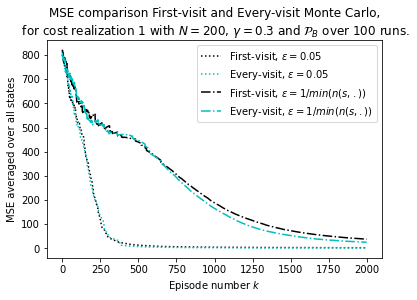

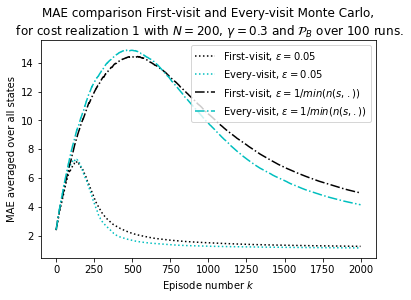

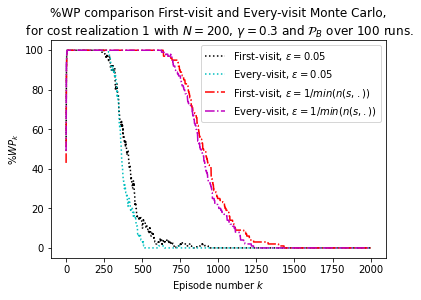

In [7]:
fig0, ax0 = plt.subplots()


ax0.plot(np.arange(nrepisodes),MSE_FV_0,'k:',label='First-visit, $\epsilon=0.05$')

ax0.plot(np.arange(nrepisodes),MSE_EV_0,'c:',label='Every-visit, $\epsilon=0.05$')


ax0.plot(np.arange(nrepisodes),MSE_FV_3,'k-.',label='First-visit, $\epsilon=1/min(n(s,.))$')

ax0.plot(np.arange(nrepisodes),MSE_EV_3,'c-.',label='Every-visit, $\epsilon=1/min(n(s,.))$')



plt.title(r'MSE comparison First-visit and Every-visit Monte Carlo,'+'\n for cost realization 1 with $N=200$, $\gamma=$'+str(gamma)+' and $\mathcal{P}_B$ over 100 runs.')

plt.xlabel('Episode number $k$')
plt.ylabel('MSE averaged over all states')
plt.legend() 



fig1, ax1 = plt.subplots()


ax1.plot(np.arange(nrepisodes),MAE_FV_0,'k:',label='First-visit, $\epsilon=0.05$')

ax1.plot(np.arange(nrepisodes),MAE_EV_0,'c:',label='Every-visit, $\epsilon=0.05$')


ax1.plot(np.arange(nrepisodes),MAE_FV_3,'k-.',label='First-visit, $\epsilon=1/min(n(s,.))$')

ax1.plot(np.arange(nrepisodes),MAE_EV_3,'c-.',label='Every-visit, $\epsilon=1/min(n(s,.))$')



plt.title(r'MAE comparison First-visit and Every-visit Monte Carlo,'+'\n for cost realization 1 with $N=200$, $\gamma=$'+str(gamma)+' and $\mathcal{P}_B$ over 100 runs.')

plt.xlabel('Episode number $k$')
plt.ylabel('MAE averaged over all states')
plt.legend() 




fig2, ax2 = plt.subplots()


ax2.plot(np.arange(nrepisodes),100*policy_perc_FV0,'k:',label='First-visit, $\epsilon=0.05$')
ax2.plot(np.arange(nrepisodes),100*policy_perc_EV0,'c:',label='Every-visit, $\epsilon=0.05$')
ax2.plot(np.arange(nrepisodes),100*policy_perc_FV3,'r-.',label='First-visit, $\epsilon=1/min(n(s,.))$')
ax2.plot(np.arange(nrepisodes),100*policy_perc_EV3,'m-.',label='Every-visit, $\epsilon=1/min(n(s,.))$')



plt.title(r'%WP comparison First-visit and Every-visit Monte Carlo,'+'\n for cost realization 1 with $N=200$, $\gamma=$'+str(gamma)+' and $\mathcal{P}_B$ over 100 runs.')
plt.xlabel('Episode number $k$')
plt.ylabel('%$WP_k$')
plt.legend() 

